# Preparation

In [1]:
import sys
sys.path

['D:\\bio\\jupyter_code\\Saggital',
 'D:\\anaconda\\envs\\STAGATE\\python37.zip',
 'D:\\anaconda\\envs\\STAGATE\\DLLs',
 'D:\\anaconda\\envs\\STAGATE\\lib',
 'D:\\anaconda\\envs\\STAGATE',
 '',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python37\\site-packages',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python37\\site-packages\\win32',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python37\\site-packages\\win32\\lib',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python37\\site-packages\\Pythonwin',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\stagate-1.0.1-py3.7.egg',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\win32',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\Pythonwin',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\23147\\.ipython']

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore")

In [4]:
import STAGATE

In [5]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'D:\\anaconda\envs\STAligner\Lib\R'
os.environ['R_USER'] = 'D:\\anaconda\envs\STAligner\Lib\site-packages\rpy2'

In [6]:
input_dir = 'G:/dataset/2_saggital/input/'
out_dir = 'G:/dataset/2_saggital/output/STAGATE/'
expriment_name = 'Sample2'

# section_ids = ['Anterior1','Anterior2','Posterior1','Posterior2']
# section_ids = ['Anterior1','Anterior2']
# section_ids = ['Posterior1','Posterior2']
# section_ids = ['Anterior1','Posterior1']
section_ids = ['Anterior2','Posterior2']

# load data

In [7]:
adata_list = {}
for section_id in section_ids:
    input_path = input_dir + section_id
    temp_adata = sc.read_visium(path=input_path, count_file='filtered_feature_bc_matrix.h5')
    temp_adata.var_names_make_unique()

    # Truth_df = pd.read_csv(os.path.join(input_dir, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
    # temp_adata.obs['Ground Truth'] = Truth_df.loc[temp_adata.obs_names, 1]

    # # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_path, 'truth.csv'), index_col=0)
    Ann_df.index = [str.replace(str.replace(x, '.', '-'), Ann_df['batch'][0] + '-', '') for x in Ann_df.index]
    temp_adata.obs['Ground Truth'] = Ann_df.loc[temp_adata.obs_names, 'celltype'].astype('category')
    
    # make the spot name unique
    temp_adata.obs_names = [x+'_'+section_id for x in temp_adata.obs_names]

    adata_list[section_id] = temp_adata.copy()

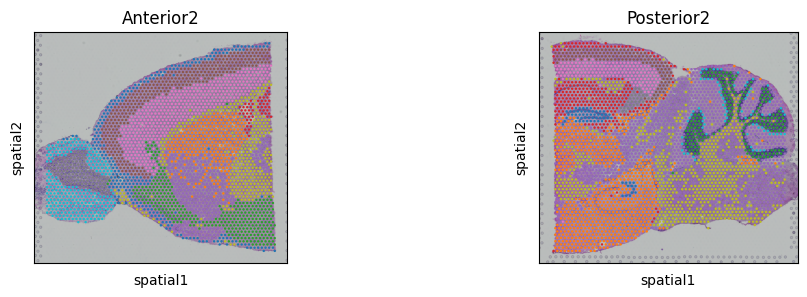

In [8]:
fig, axs = plt.subplots(1, len(section_ids), figsize=(12, 3))
it=0
for section_id in section_ids:
    if it == len(section_ids):
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["Ground Truth"], title=section_id, show=False)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["Ground Truth"], title=section_id, show=False)
    it+=1

------Calculating spatial graph...
The graph contains 16456 edges, 2825 cells.
5.8251 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 19246 edges, 3293 cells.
5.8445 neighbors per cell on average.


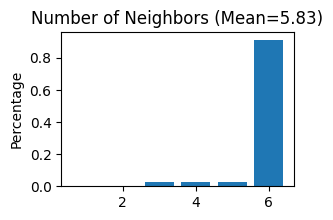

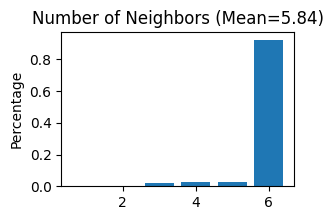

In [9]:
for section_id in section_ids:
    STAGATE.Cal_Spatial_Net(adata_list[section_id], rad_cutoff=150)
    STAGATE.Stats_Spatial_Net(adata_list[section_id])

# Conbat the scanpy objects and spatial networks

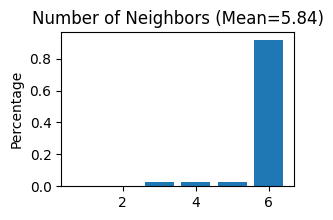

In [10]:
adata = sc.concat([adata_list[x] for x in section_ids], keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net'] for x in section_ids])
STAGATE.Stats_Spatial_Net(adata)

# Normalization

In [11]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Running STAGATE

In [12]:
adata

AnnData object with n_obs × n_vars = 6118 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'spatial'

In [13]:
%%time
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (6118, 3000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:25<00:00,  1.88it/s]

Wall time: 4min 26s


In [14]:
print(adata)
print(type(adata.obsm['STAGATE']))

AnnData object with n_obs × n_vars = 6118 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'spatial', 'STAGATE'
<class 'numpy.ndarray'>


#### save embedding

In [15]:
# save embedding
np.savetxt(out_dir + expriment_name + '_STAGATE.csv', adata.obsm['STAGATE'], delimiter=",")

In [16]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

# louvein
# sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=eval_resolution)

adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=num_cluster)

ModuleNotFoundError: No module named 'importlib.metadata'

In [ ]:
adata.obs['batch_name'] = [x.split('_')[-1] for x in adata.obs_names]

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='batch_name')

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Ground Truth')

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='mclust')

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_ids:
    adata_list[section_id].obs['STAGATE'] = adata.obs.loc[adata_list[section_id].obs_names, 'mclust']
    if it == 3:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["STAGATE"], title=section_id, show=False)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["STAGATE"], title=section_id, show=False)
    it+=1

# Calculate ARI

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

for section_id in section_ids:
    temp_adata = adata[adata.obs['batch_name']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['Ground Truth'])
    print('ARI of section ID %s: %.3f' %(section_id, temp_ARI))

# Visualization

In [ ]:
sc.pp.neighbors(adata, use_rep='STAGATE', random_state=666)
sc.tl.umap(adata, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(section_ids, section_color))
adata.uns['batch_name_colors'] = [section_color_dict[x] for x in adata.obs.batch_name.cat.categories]
# adata.obs['mclust'] = pd.Series(ST_utils.match_cluster_labels(adata.obs['Ground Truth'], adata.obs['mclust'].values),
#                                          index=adata.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata, color=['batch_name', 'Ground Truth', 'mclust'], ncols=3,
           wspace=0.5, show=False)
plt.savefig(out_dir + expriment_name + '_umap.png', dpi=300)

In [ ]:
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['mclust'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)

plt.savefig(out_dir + expriment_name + '_ARI.png', dpi=300)
plt.show()

# save

In [17]:
print(type(adata))
print(adata.obsm)
print(adata)

print(adata.isbacked)
adata.filename = out_dir + expriment_name + '.h5ad'
print(adata.isbacked)

<class 'anndata._core.anndata.AnnData'>
AxisArrays with keys: spatial, STAGATE
AnnData object with n_obs × n_vars = 6118 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'spatial', 'STAGATE'
False
True
